# Deep Generative Models : USE CASE GAN

© Deep Learning Indaba. Apache License 2.0.

## Introduction


Generative modeling are an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. <br>
They are mainly used for:
- anomaly detection 
- image translation 
- image enhancement 
- data augmentation ...

In this tutorial we will investigate what a generative network is.We will do so by learning  Generative Adversarial Networks (GANs)
## Learning Objectives

* Get a feel for what a generative model is.
* Have an oveview of some generatives models
* Understand GAN and being able to train a GAN model  on images

## Running on GPU

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box. This is all you need to do, Colab and TensorFlow will take care of the rest!




In [1]:
!nvidia-smi

Sun Aug 29 08:26:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip uninstall -y tensorflow
#!pip install tensorflow

In [3]:
#@title Imports (RUN ME!) { display-mode: "form" }
#!pip install tensorflow-gpu

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

print("TensorFlow executing eagerly: {}".format(tf.executing_eagerly()))

TensorFlow executing eagerly: True


## The data



For this practical, we will use the Fashion MNIST dataset consisting of 70,000 greyscale images of clothing items and their labels. The dataset is divided into 60,000 training images and 10,000 test images. However, unlike in the *supervised learning* setting that we have been exposed to in the previous practicals, because we are doing *unsupervised learning* in this practical, we will not make use of the labels. In this practical, our goal is not to learn labels for images, but rather to learn to generate (hopefully) new and unique images.

Regarding our task of generating images, you may be wondering why we care about doing this! One simple reason we're spending time on this is that it is a fun application of generative models, which gives us an excellent visual way of exploring how different models work. However, generating images itself has many interesting applications ranging from creating new fonts to making people smile in pictures, and from assisting with interactive design to creating photo-realistic images from drawn outlines (see [this cool article](https://distill.pub/2017/aia/) for more 
information on these applications). <br>
 It should also be noted that many of the techniques presented in this practical apply to generative modelling in general and not just to generating images. Generative modelling has many interesting applications ranging from anomaly detection to missing data imputation, as well as, in leveraging abundant unsupervised data for representation learning (e.g. [BigBiGAN](https://www.google.com/url?q=https://arxiv.org/abs/1907.02544)).

In [4]:
!pip show tensorflow

Name: tensorflow
Version: 2.6.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: tensorboard, keras, opt-einsum, termcolor, google-pasta, absl-py, grpcio, gast, astunparse, six, clang, keras-preprocessing, h5py, wrapt, protobuf, typing-extensions, wheel, numpy, flatbuffers, tensorflow-estimator
Required-by: kapre


In [5]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
# We are getting the labels only for the pruposes of exploring the data,
# we won't use them to train our models (or will we?).
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# 10 classes
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4431872/4422102 [==============================] - 0s 0us/step


#### Visualize the data



Each image in the dataset consists of a 28 x 28 matrix of greyscale pixels. The values are between 0 and 255 where 0 represents black, 255 represents white, and there are many shades of grey in-between. Each image is assigned a corresponding numerical label, between 0 and 9, so the image in `train_images[i]` has its corresponding label stored in `train_labels[i]`. We also have a lookup array called `text_labels` to associate a text description with each of the numerical labels. For example, the label 1 is associated with the text description "Trouser".

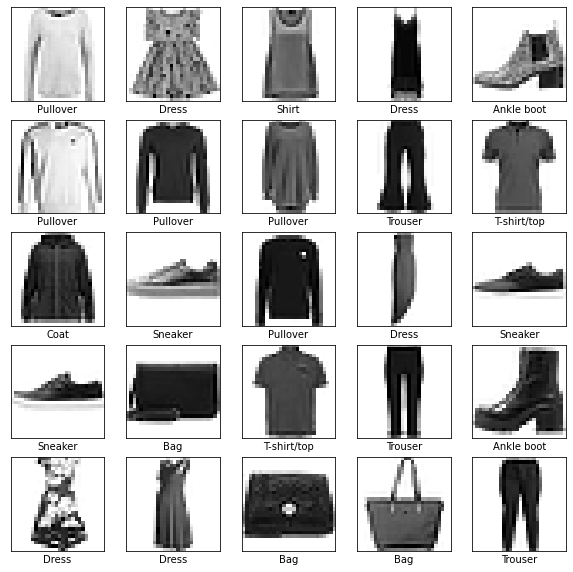

In [6]:
# Show 25 randomly selected images at a time
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap="gray_r")
    plt.xlabel(text_labels[train_labels[img_index]])

# Overview on Deep Generative Models

Deep generative models have shown an incredible ability to produce highly realistic pieces of content of various kind, such as images, texts and sounds. Among these deep generative models, two major families stand out and deserve a special attention: Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).

### Variational Autoencoder (VAE)

VAEs are extensions of AE. Autoencoders are networks trained unsupervised on input data (often images) that attempt to find a simple *code* to represent the input data. The main idea is to jointly train two sub-networks to cooperate: <br>
- *encoder* network, which takes an image and turns it into a code. The code is often called the *latent code* or *latent variable*, which lives in a *latent space*. 
- *decoder* network, which takes a code and turns it back into a reconstructed image. (For non-image data, the basic idea is the same). The two approches share many similarities. <br>
The main difference is that rather than the encoder producing a code for a given input and the decoder using that code to reconstruct that input, **the encoder of a VAE produces the parameters of a probability distribution that explains the data**. <br>
The generative capabilities is enable by this latent code.
More specifically, it produces the distribution $p(z|x)$. Then, given samples from this distribution, **the decoder generates new input data samples**. In other words, we have learnt a latent variable model for the data.  <br>

 ![](https://drive.google.com/uc?id=1zORCE2DkuhYv08w-iXCHzAjLfXbAkvxt)


VAE are easier and faster to train but  their results are in general blurry .















## Generative Adversarial Networks : GAN




![image](https://thispersondoesnotexist.com/image)

GAN is one of the approaches in deep generative modelling that is becoming really popular right now.

it is consisting of two networks: <br>

• Generator G : network that take noise as input and generate sample. <br>

• Discriminator D : network that evaluate generated sample (fake) and training set to distinguish between real one and fake. <br>

It is an adversarial process in which the two network are trained simultaneously. The generator learn
the data distribution and the discriminator estimate the probability that a given image came from the training data rather than the generated data. <br>



[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs), are a very popular class of deep generative models which have shown some incredible results in generating images. For example, take a look at the progress that has been made in generating pictures of people's faces, taken from Ian Goodfellow's [twitter](https://www.google.com/url?q=https://twitter.com/goodfellow_ian/status/1084973596236144640&sa=D&ust=1565613603406000&usg=AFQjCNEtcXzfgDqPL0vPBkDJhl-x2Iup_Q_):

![faces](https://pbs.twimg.com/media/Dw6ZIOlX4AMKL9J.jpg)

<BR>

The idea behind GANs is to train two networks simultaneously.<BR> Firstly, a **generator network**, which we can train to take a random input (often called $z$) and produce a sample from some distribution, in this case, the distribution of 28 x 28 grayscale clothing images. Secondly, we have a **discriminator network**, which will learn to tell apart the real (training) data and the fake (generated) data. The generator is trained to trick the discriminator and the discriminator is trained to avoid being tricked. This process is described in the following diagram:

<br>


![GAN](https://drive.google.com/uc?id=1d9FrDGFWWCRJJkeoI9N2fQnezaZu05x4)

<br>
As you can see in the above diagram, the discriminator's loss is calculated from using the labels (real or fake) for the generated and training images. <br>
We can use the standard cross-entropy loss function for a binary classifier. However, more interestingly, the generator's loss comes from performing back-propagation through the discriminator. In a sense, **the discriminator is the loss function for the generator**. While it may seem strange to train a neural network using another neural network as the loss function, rather than some pre-defined function, it turns out that training this way approximately minimizes something called the Jensen-Shannon divergence (JSD), which is a well motivated choice of loss function for generative models that we would be unable to calculate analytically.


<br>


### Optional extra reading: The Jensen-Shannon Divergence

As mentioned above, the discriminator is used as a loss function to train the generator, and it approximates something called the Jensen-Shannon divergence (JSD). Let's take a closer look at what the JSD is and how it is approximated.

We can, and will in just a moment, prove that using an optimal discriminator (one that makes the fewest mistakes possible) to train the generator is equivalent to minimizing the JS-divergence between the distributions of the generated and real images. Of course, in practice, we do not necessarily have an optimal discriminator, and so we end up with some approximation of the JSD. 

Okay, but what exactly is the Jensen-Shannon Divergence? In short, **the JSD is simply a method for measuring the similarity between two probability distributions**. It is defined as:

\begin{equation}
 D_{JS}(P||Q) = \frac{1}{2}D_{KL}(P,M) + \frac{1}{2}D_{KL}(Q,M)
\end{equation}

where $P$ and $Q$ are the distributions we want to measure the similarity between, $M = \frac{P + Q}{2}$ is the average of $P$ and $Q$, and $D_{KL}$ is the Kulback-Liebler Divergence (KLD). Don't worry too much about the funny $||$ notation, you can think of $D(P||Q)$ as being the same as $D(P,Q)$, just a function that takes two distributions as inputs and returns a scalar similarity between them.

Okay, but what exactly is the Kulback-Liebler Divergence? As you might have guessed from the word "divergence" in both the KLD and JSD, the KLD is also a measure of similarity between probability distributions. It is defined as:

\begin{equation}
D_{KL}(P||Q) = \sum_x P(x)\log\frac{P(x)}{Q(x)}
\end{equation}

in the case where $P$ and $Q$ are discrete distributions (the sum is replaced by an integral for continuous distributions). From the formula above we can see that the KLD will be 0 if and only if $P = Q$ and will be greater than 0 otherwise. We can also see that $D_{KL}(P,Q) \neq D_{KL}(Q,P)$. 

**Exercise:** explain to the person next to you why $D_{KL}(P,Q) = 0$ iff $P = Q$.

**Exercise:** explain to the person next to you why $D_{KL}(P,Q) \neq D_{KL}(Q,P)$.

**Advanced Excercise:** why can we not calculate the JSD in practice? If we could we wouldn't need to do GAN training. *Hint* think about what quantities we need to calculate the JSD.

#### Proof that using the optimal discriminator as the loss function for the generator is the same as minimizing the JSD

The loss we are minimizing is

$$\mathbb{E}_{x \sim p_d(x)}[\log D^*(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D^*(G(z)))]$$ 

where $p_d(x)$ is the training data distribution, $p_z(z)$ is the random noise distribution from which we draw samples to pass through our generator, $D$ and $G$ are the discriminator and generator, and $D^*$ is the optimal discriminator which has the form:

$$ D^*(x) = \frac{p_d(x)}{p_d(x) + p_g(x)}.$$

Here $p_g(x)$ is the distribution of the data sampled from the generator. The form for this optimal discriminator comes from Bayes' rule.

**Exercise:** derive the form of the optimal discriminator given above. *Hint:* The discriminator has to output the probability that an image ($x$) is real, $p_d(x)$ is the probability of the image under the real/training data distribution,  $p_g(x)$ is the probability of the image under the fake/generated data distribution, and we have no prior knowledge about whether a given image is real or fake. 

Substituting $D^*(x)$ and $p_g(x)$ into our loss, we can rewrite it as

$$ \mathbb{E}_{x \sim p_d(x)}[\log \frac{p_d(x)}{p_d(x) + p_g(x)}] + \mathbb{E}_{x \sim p_g(x)}[\log \frac{p_g(x)}{p_d(x) + p_g(x)}]. $$

Now we can multiply the values inside the logs by $1 = \frac{0.5}{0.5}$ to get

 $$ \mathbb{E}_{x \sim p_d(x)}[\log \frac{0.5 p_d(x)}{0.5(p_d(x) + p_g(x))}] + \mathbb{E}_{x \sim p_g(x)}[\log \frac{0.5 p_g(x)}{0.5(p_d(x) + p_g(x))}]. $$

Recall that $\log(ab) = \log(a) + \log(b)$ (log multiplication law) and define $p_m(x) = \frac{p_d(x) + p_g(x)}{2}$, we now get

 $$ \mathbb{E}_{x \sim p_d(x)}[\log \frac{p_d(x)}{p_m(x)}] + \mathbb{E}_{x \sim p_g(x)}[\log \frac{p_g(x)}{p_m(x)}] - 2\log2. $$

Using the definition of the KL-Divergence, this simplifies to

$$ D_{KL}(p_d||p_m) + D_{KL}(p_g||p_m) - 2\log2. $$

Now, noting that for the purposes of optimization the $2\log2$ term can be ignored and that similarly we can multiply the above by a constant factor of 0.5, we get

$$ \frac{1}{2} D_{KL}(p_d||p_m) + \frac{1}{2} D_{KL}(p_g||p_m) $$

Finally, using the definition of the JS-Divergence, we get

$$ D_{JS}(p_d||p_g).$$

## Training a GAN



Training a GAN model is min-max game.
Now that we know what a GAN is let's try training one to generate images of clothing! Before we train our model, we first need to process our training data, and we'll need to decide on our model architecture. Remember that a GAN consists of two networks, so we'll have to define both of them.

#### Some data pre-processing




We need to do a little data pre-processing before training our GAN:

1. We add an extra dimension because many of the layers we will use expect a channel dimension. 
2. We normalize the images to be in the range [-1, 1] because we are using the DCGAN guidelines, described below.
3. We randomize and batch the data.

In [7]:
gan_train_images = np.expand_dims(train_images, axis=3) # add a channel dim
gan_train_images = gan_train_images.astype('float32') # convert to float32
gan_train_images = (gan_train_images - 127.5) / 127.5 # normalize the images to [-1, 1]
batch_size = 256
gan_train_dataset = tf.data.Dataset.from_tensor_slices(gan_train_images).shuffle(batch_size*10).batch(batch_size)

### The model

Let's think about how our two networks must be structured. 

The *discriminator* should take a 28x28x1 array of numbers in the range [-1, 1] as its input and return a scalar between 0 and 1. This scalar will be interpreted as the probability the image came from the training dataset rather than being generated by the generator, i.e. the probability that the image is real rather than fake.

The *generator* should take a vector and return a 28x28x1 array of numbers in the range [-1, 1]. The size of the vector is the *latent dimension* and is a hyperparameter that we can tune. 

One of the most challenging parts of deep learning is choosing the architecture for our models. This issue is highlighted for GAN training, which is notoriously tricky. A GAN might work correctly with one architecture and fail to train at all with a slightly different architecture.  Furthermore, instabilities and pathologies are very common in GAN training, for example, the generator and discriminator might end up chasing each other in circles rather than converging. The good news is that GANs are an active area of research and several methods exist for making GANs train more reliably. <br>


One such method that works very well for images is the Deep Convolution Generative Adversarial Network (DCGAN) architecture by _Radford et al._ which we will draw inspiration from to design our networks. 

![](https://drive.google.com/uc?id=17BR9jpGmdNnEY_XQThM87bmsmIhzyQbM)
<br>
Here are some tips from the [git repo](https://github.com/Newmu/dcgan_code) for DCGAN:

* Replace any pooling layers with strided convolutions.
* Use batchnorm in both the generator and the discriminator (standardize technique to accelerate training)
* Remove fully connected hidden layers for deeper architectures. Just use average pooling at the end. 
* Use ReLU activations in the generator for all layers except for the output, which uses Tanh. *(This means they are generating pixel values between -1 and 1.)*
* Use LeakyReLU activation in the discriminator for all layers.

We will use these guidelines to help us define our discriminator and generator, but you should experiment and see what happens if you make other choices.



In [8]:
# some useful constants and hyper-parameters
img_shape = (28, 28, 1)
latent_dim = 100

#### The generator

In [9]:
def make_generator(latent_dim):
  generator = tf.keras.Sequential(name="generator")
  
  # we start with 7 * 7 * XXX so that we can apply two blocks that include
  # UpSampling layers, which will eventually give us a 28 * 28 image, since
  # 7 * 2 * 2 = 28
  generator.add(tf.keras.layers.Dense(7 * 7 * 128,
                                activation="relu",
                                input_dim=latent_dim))

  assert generator.input_shape == (None, latent_dim), "input is wrong shape"
  
  generator.add(tf.keras.layers.Reshape([7, 7, 128]))
  
  generator.add(tf.keras.layers.UpSampling2D())
  generator.add(tf.keras.layers.Conv2D(128,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  generator.add(tf.keras.layers.Activation("relu"))
  
  generator.add(tf.keras.layers.UpSampling2D())
  generator.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  generator.add(tf.keras.layers.Activation("relu"))
  
  generator.add(tf.keras.layers.Conv2D(1,
                                 kernel_size=3,
                                 padding="same"))
  generator.add(tf.keras.layers.Activation("tanh"))
  
  assert generator.output_shape == (None, 28, 28, 1), "output is wrong shape"
  
  return generator
  
generator = make_generator(latent_dim)    

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0 

We can (try to) generate an image with our un-trained generator.

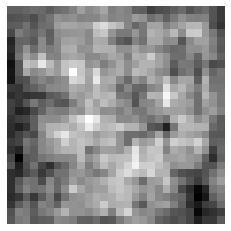

In [10]:
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
plt.axis('off')
plt.show()

#### The discriminator

In [11]:
def make_discriminator(img_shape):
  discriminator = tf.keras.Sequential(name="discriminator")
  
  discriminator.add(tf.keras.layers.Conv2D(32,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same",
                                  input_shape=img_shape))

  assert discriminator.input_shape == (None, 28, 28, 1), "input is wrong shape"
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(64,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(128,
                                  kernel_size=3,
                                  strides=2,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Conv2D(256,
                                  kernel_size=3,
                                  strides=1,
                                  padding="same"))
  discriminator.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  
  discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  discriminator.add(tf.keras.layers.Dropout(0.25))
  discriminator.add(tf.keras.layers.Flatten())
  discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  
  assert discriminator.output_shape == (None, 1), "output is wrong shape"
    
  return discriminator
  
discriminator = make_discriminator(img_shape)    

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)        

We can also (try to) make predictions about whether an image is real or fake with our un-trained discriminator.



In [12]:
decision = discriminator(generated_image)
# probalility of the output to be a real image : if near 1 it's real and near 0 it'a a fake image
print (decision)

tf.Tensor([[0.49933782]], shape=(1, 1), dtype=float32)


### Optional extra reading: generative vs discriminative models



You should already be starting to notice some of the differences between generative and discriminative models. For example, we've said that we are now doing unsupervised learning and that we do not need labels for our data. So you might now be wondering if this is always the case and whether there are other differences between the two kinds of models. In general, *generative models are not always unsupervised*; they can also be supervised or even semi-supervised. In these cases, labels are often used. Similarly, unsupervised learning is not always generative, for example, k-means clustering. The main difference between generative and discriminative modelling is the goal. The purpose of a discriminative model is to predict an output $y$ given an input $x$, as acurately as possible. On the other hand, the purpose of a generative model is to describe the process in which data is generated. This lets us create new examples of the data, often written $\hat x$, but it can also help us to understand the underlying nature of the data. 

We can summarise the above by saying discriminative models learn $p(y | x)$, whilst generative models learn *something* about $p(x)$. But what do we mean by 'something'? Let's get an idea by taking a look at what a few different kinds of models learn:

* GANs learn to sample from $p(x)$.
* VAEs learn to approximate $p(x)$.
* Conditional VAEs learn to approximate $p(x|y)$.
* Normalizing flows learn $p(x)$ exactly.
* Auto-regressive models learn $p(x_i|x_{i-1},x_{i-2},...,x_1)$.

**Partner exercise:** considering the following list of applications for generative modelling, which of the models above are applicable, and which aren't: anomaly detection, filling in missing data, generating images of numeric digits, generating images of specific digits, unsupervised representation learning, generating time-series data.



### Training the model

#### Defining the loss functions and optimizers

Lets first define the discriminator loss. Recall that the discriminator is trained to determine whether images are real or fake. In other words, the discriminator is a binary classifier that predicts either "real" or "fake" for a given image. In this case, we will train the discriminator to predict `1` for a real image and `0` for a fake image so we can use a standard loss for a binary classifier: cross entropy. The only thing we need to take care of is combining the losses for a batch of generated images and a batch of real images. 

In [13]:
# define the loss function for the discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    # real_output is the prediction of the discriminator for a batch of real images
    # fake_output is the same but for images from the generator
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Now we can define the generator loss. Recall that the generator is trained to trick the discriminator. As a result, our loss function must make use of the discriminator's predictions for the fake/generated images. However, in this case, we are training the generator such that the discriminator predicts `1` for a fake image (which is the opposite of what we did for the discriminator above).

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Finally, because we are training two networks for two different tasks, we need two different optimizers. Here the optimizers are identical, but the choice of the optimizer, learning rate, and other parameters are all things we can tweak to try to improve training.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

####The training loop

Because GAN training requires that we simultaneously train a generator network and a discriminator network, using the Keras `model.fit()` function has issues - for more complex training setups like this, it will be easier to define the training loop using `tf.GradientTape()`.

In [16]:
# if you change the definitions for the generator and/or discriminator,
# or if you want to restart training...
# RE-RUN THIS CELL!

gen_loss_mean = tf.keras.metrics.Mean(name='gen_loss_mean')
disc_loss_mean = tf.keras.metrics.Mean(name='disc_loss_mean')

@tf.function
def train_step(images):                                       
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gen_loss_mean(gen_loss)
    disc_loss_mean(disc_loss)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
# Exercise: why do we define this as a constant?
## Draw random samples from a normal (Gaussian) distribution dim 8x100 : 8 noise vector of 100
noise = np.random.normal(0, 1, (8, latent_dim))

def generate_and_display_images(generator):
    predictions = generator(noise, training=False)
      
    fig = plt.figure(figsize=(16,2))

    for i in range(predictions.shape[0]):
      plt.subplot(1, 8, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray_r')
      plt.axis('off')

    plt.show()
    
def train_GAN(epochs):
  generate_and_display_images(generator)
  
  for epoch in range(epochs):
    start = time.time()

    for image_batch in gan_train_dataset:
      train_step(image_batch)
      
    template = 'Epoch {:03d}: time {:.3f} sec, gen loss {:.3f}, disc loss {:.3f}'
    print(template.format(epoch + 1, time.time()-start, gen_loss_mean.result(), disc_loss_mean.result()))
    
    generate_and_display_images(generator)
    
generator = make_generator(latent_dim)
discriminator = make_discriminator(img_shape)

Let's train our GAN! 30 epochs are around when we start to see reasonable results, which will take about 10 mins to train using a GPU in Colab ( Tesla K80). If you have time, try training for 50 epochs and see how much of a difference there is (or isn't). 

In [17]:
import time

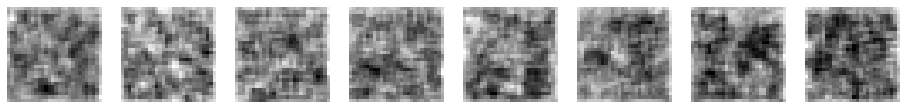

Epoch 001: time 30.240 sec, gen loss 1.999, disc loss 1.043


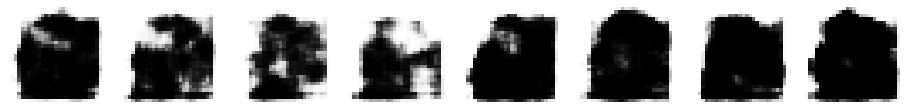

Epoch 002: time 24.389 sec, gen loss 2.310, disc loss 0.988


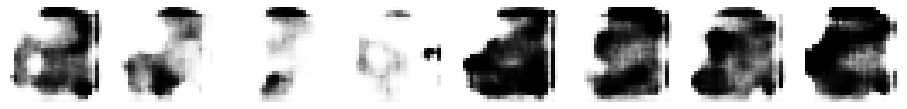

Epoch 003: time 24.455 sec, gen loss 2.188, disc loss 0.975


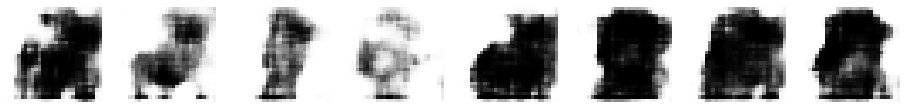

Epoch 004: time 24.716 sec, gen loss 2.061, disc loss 0.962


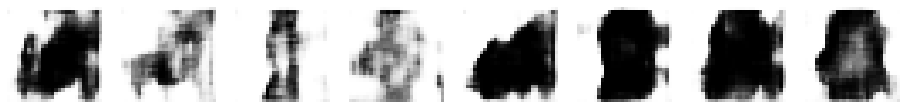

Epoch 005: time 24.786 sec, gen loss 1.972, disc loss 0.946


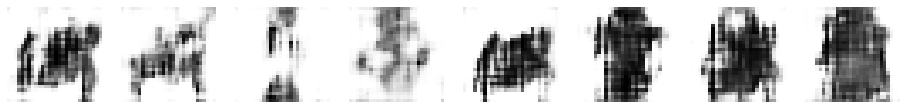

Epoch 006: time 24.685 sec, gen loss 1.926, disc loss 0.935


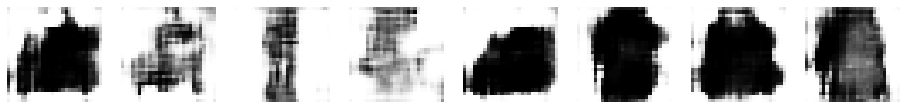

Epoch 007: time 24.587 sec, gen loss 1.917, disc loss 0.906


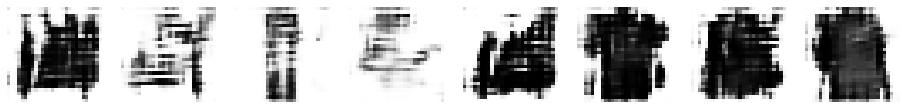

Epoch 008: time 24.586 sec, gen loss 1.911, disc loss 0.893


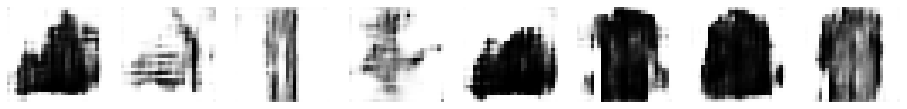

Epoch 009: time 24.608 sec, gen loss 1.904, disc loss 0.880


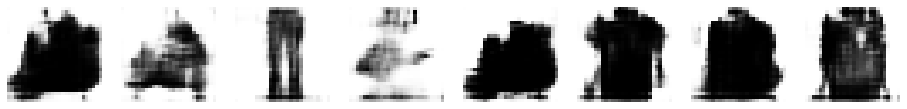

Epoch 010: time 24.611 sec, gen loss 1.899, disc loss 0.868


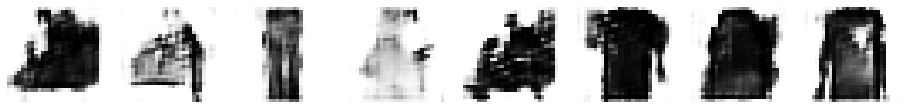

Epoch 011: time 24.579 sec, gen loss 1.901, disc loss 0.860


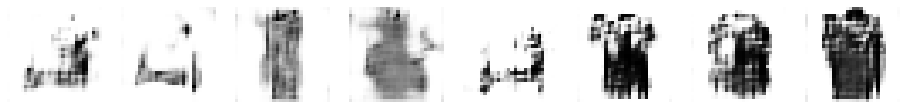

Epoch 012: time 24.633 sec, gen loss 1.893, disc loss 0.851


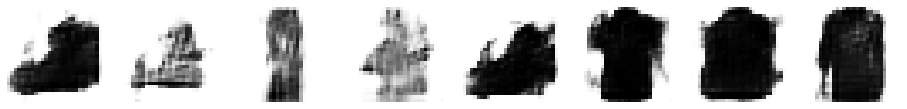

Epoch 013: time 24.608 sec, gen loss 1.886, disc loss 0.845


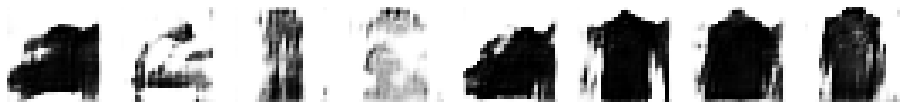

Epoch 014: time 24.490 sec, gen loss 1.871, disc loss 0.849


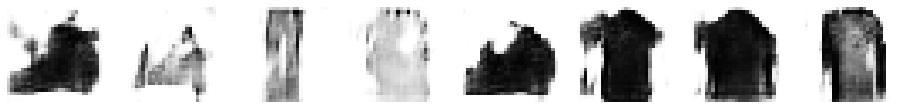

Epoch 015: time 24.495 sec, gen loss 1.858, disc loss 0.850


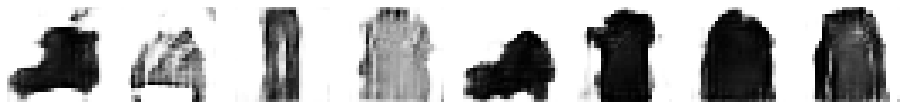

Epoch 016: time 24.587 sec, gen loss 1.852, disc loss 0.848


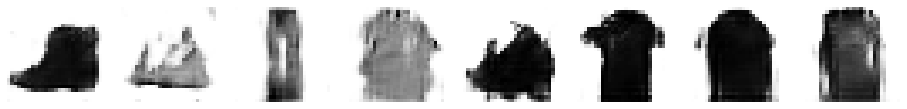

Epoch 017: time 24.532 sec, gen loss 1.841, disc loss 0.850


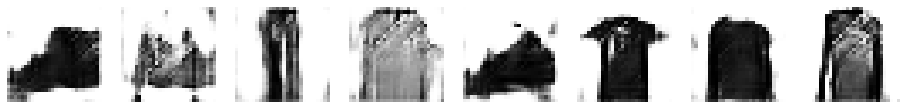

Epoch 018: time 24.500 sec, gen loss 1.833, disc loss 0.854


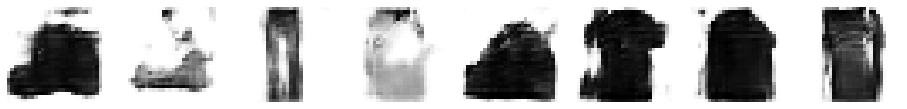

Epoch 019: time 24.547 sec, gen loss 1.823, disc loss 0.856


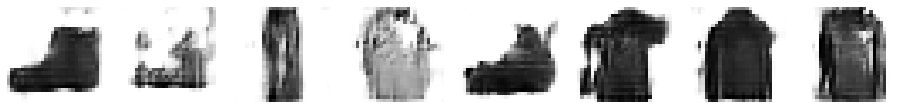

Epoch 020: time 24.600 sec, gen loss 1.814, disc loss 0.856


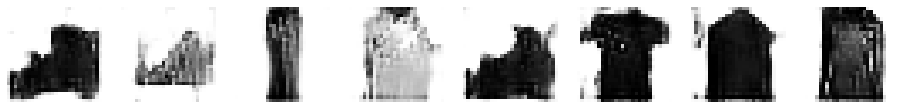

Epoch 021: time 24.462 sec, gen loss 1.807, disc loss 0.856


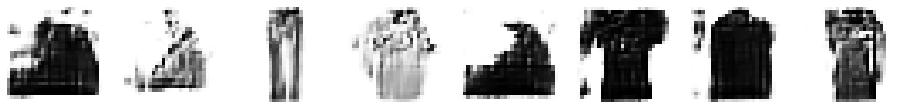

Epoch 022: time 24.536 sec, gen loss 1.798, disc loss 0.861


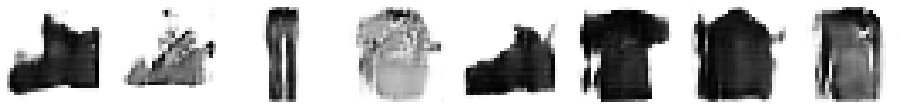

Epoch 023: time 24.571 sec, gen loss 1.791, disc loss 0.864


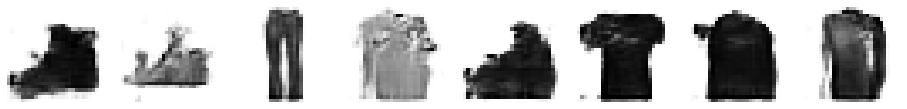

Epoch 024: time 24.495 sec, gen loss 1.780, disc loss 0.867


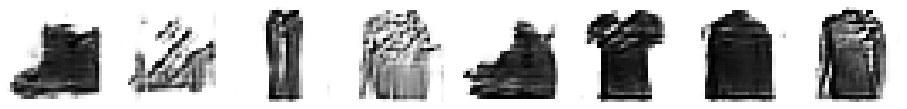

Epoch 025: time 24.484 sec, gen loss 1.771, disc loss 0.869


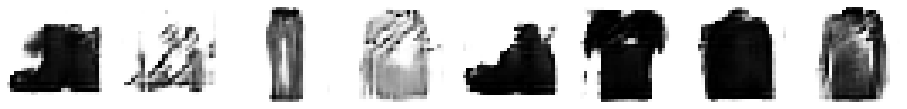

Epoch 026: time 24.526 sec, gen loss 1.763, disc loss 0.872


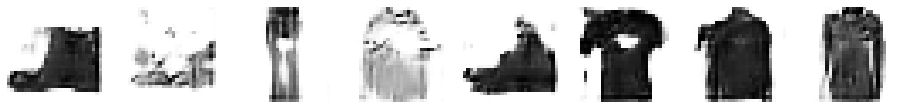

Epoch 027: time 24.410 sec, gen loss 1.752, disc loss 0.877


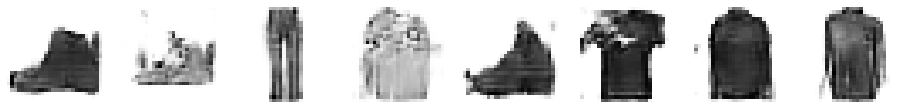

Epoch 028: time 24.440 sec, gen loss 1.742, disc loss 0.880


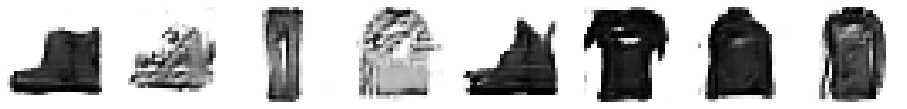

Epoch 029: time 24.532 sec, gen loss 1.733, disc loss 0.884


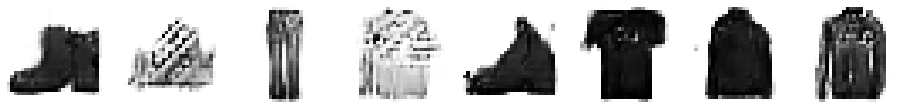

Epoch 030: time 24.487 sec, gen loss 1.724, disc loss 0.887


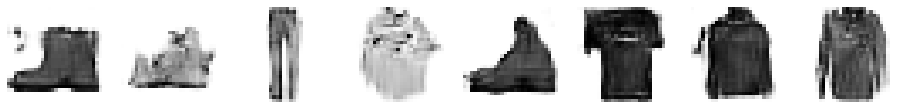

CPU times: user 2min 46s, sys: 30.4 s, total: 3min 17s
Wall time: 12min 36s


In [18]:
%%time
num_epochs = 30
train_GAN(num_epochs)

There you have it; we've successfully trained a GAN to generate images of clothing. There is certainly room for improvement, but comparing the results after our last epoch to the "image" generated by the untrained generator shows that our GAN training worked.


## Conclusion






This practical has given an overview of deep generative models and  namely GANs . 

Deep Learning models are really achieving human level performance in supervised learning but the same is not true for unsupervised learning. Nevertheless, deep learning scientists are working hard to improve the performance of unsupervised models. 
In this tutorial, we have learn to train a GAN model using some tips to make it converging faster.

 But there are problems with GANs such as stabilizing their training which is still an active area of research.
<br> However GANs are really powerful and currently they are being used in a variety of tasks such as high quality image and video generation, text to image translation, image enhancement, reconstruction of 3D models of objects from images, music generation, cancer drug discovery etc. Besides this, many deep learning researchers are also working to unify these two models and to get the best of both these models. Seeing the increasing rate of advancement of Deep Learning, we believe that GANs will open many closed doors of Artificial Intelligence such as Semi-supervised Learning and Reinforcement Learning. In the next few years, generative models is going to be very helpful for graphics designing, designing of attractive User-Interfaces etc. It may also be possible to generate natural language texts using Generative Adversarial Networks.

However, you shouldn't think that there aren't any other methods out there. Other important kinds of generative models include:

*  [Normalizing flows](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html) (e.g. [RealNVP](https://arxiv.org/abs/1605.08803_), [Glow](https://arxiv.org/abs/1807.03039))
*  Auto-regressive models (e.g. [WaveNet](https://arxiv.org/pdf/1609.03499.pdf), [PixelRNN](https://arxiv.org/pdf/1601.06759.pdf), [PixelCNN](https://arxiv.org/pdf/1606.05328.pdf))
*  and a whole range of non-deep learning related models such as [Latent Dirichlet Allocation](http://ai.stanford.edu/~ang/papers/jair03-lda.pdf).




## Extra reading on GANs

* [GAN Lab](https://poloclub.github.io/ganlab/) (an interactive GAN visualization, **highly recommended**)
* [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) (Goodfellow's original paper) 
* [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) (the DCGAN architecture by _Radford et al._)
* [GAN Hacks](https://github.com/soumith/ganhacks) (more tips and tricks for training GANs from various authors of influencial GAN papers)
* [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160) (a tutorial by Goodfellow)
* [Depth First Learning: Wasserstein GAN](http://www.depthfirstlearning.com/2019/WassersteinGAN) (a self-study guide to WGAN with plenty of excellent resources for understanding generative models and GANs)
* [TF 2.0 GAN Example](https://www.tensorflow.org/beta/tutorials/generative/dcgan)

